In [0]:
import re

import pickle
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

!pip install spacy
import spacy
!python -m spacy download en_core_web_sm

from pprint import pprint

!pip install gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

!pip install wordcloud
from wordcloud import WordCloud

!pip install nltk
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize

nltk.download('punkt')
nltk.download('stopwords')

!pip install pyLDAvis

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Requirement already up-to-date: textblob in /usr/local/lib/python3.6/dist-packages (0.15.3)
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nlt

In [0]:
from google.colab import files,drive
#uploaded = files.upload()

drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import os
os.chdir("/content/drive/My Drive/")

# **Word Cloud of the most frequent words in terms of frequency**

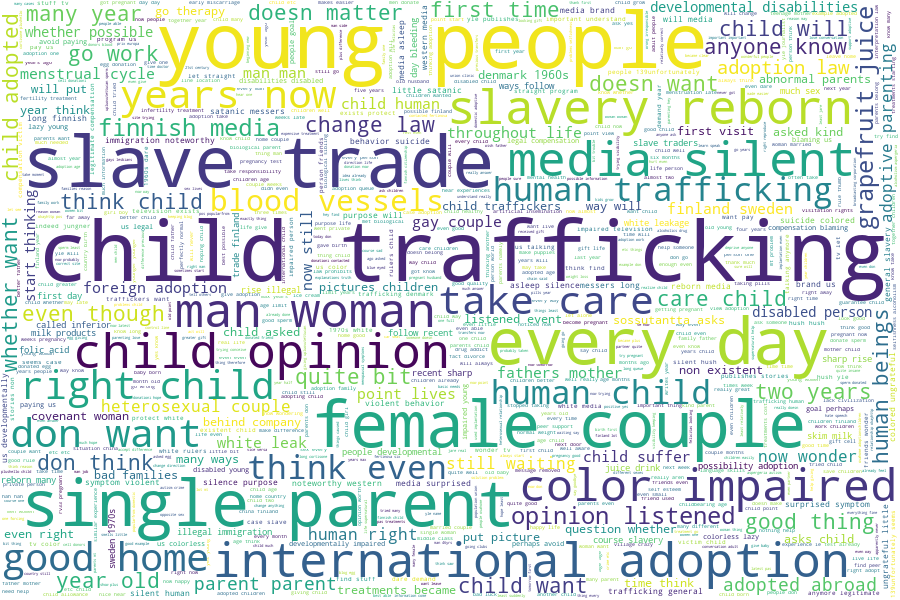

In [0]:
pickle_in = open('Dataset.pkl',"rb")
Dataset = pickle.load(pickle_in)
Texts = ''
for Topic in Dataset:
    Texts += Topic['Title']+Topic['Text']
    if len(Topic['Comments']) > 0:
       Texts += '\n'.join(comment for comment in Topic['Comments'])

Texts = re.sub('[,\.!?]', '', Texts)    
Texts = Texts.lower()    
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=10000, contour_width=5, contour_color='steelblue',width=900, height=600)
# Generate a word cloud
wordcloud.generate(Texts)
# Visualize the word cloud
wordcloud.to_image()

##**Text preprocessing functions**

In [0]:
def Dict2List(Dataset, keys = []):
    List = []
    for Topic in Dataset:
        for key in keys:
            if isinstance(Topic[key], list):
               List.extend(Topic[key])
            else:
                List.append(Topic[key])
    return List

def Cleaning(Sentences):
    # Remove Emails
    Sentences = [re.sub('\S*@\S*\s?', '', sent) for sent in Sentences]
    # Remove new line characters
    Sentences = [re.sub('\s+', ' ', sent) for sent in Sentences]
    # Remove distracting single quotes
    Sentences = [re.sub("\'", "", sent) for sent in Sentences] 
    return Sentences
    
def sent_to_words(Sentences):
    for sentence in Sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))# deacc=True removes punctuations

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwords.words('english')] for doc in texts]

def make_bigrams(texts,bigram_mod):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    nlp.max_length = 21085330

    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

##**Top 10 Topics using topic Modeling (LDA)**



In [0]:
'https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/'
def LDA(Texts):
    Sentences = Cleaning(sent_tokenize(Texts))
    data_words = list(sent_to_words(Sentences))
    # Remove Stop Words
    data_words = remove_stopwords(data_words)
    
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    #trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    #trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words,bigram_mod)

    return data_words_bigrams

def LDA2(data_words_bigrams):  
    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)

    # Create Corpus
    texts = data_lemmatized

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    
    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    
    pprint(lda_model.print_topics())
    doc_lda = lda_model[corpus]
    
    # Compute Perplexity
    print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)
    
    return lda_model,id2word,corpus

In [0]:
data_words_bigrams = LDA(Texts)

In [0]:
lda_model,id2word,corpus = LDA2(data_words_bigrams)

[(0,
  '0.024*"child" + 0.016*"would" + 0.011*"even" + 0.009*"time" + 0.008*"go" + '
  '0.008*"year" + 0.008*"think" + 0.008*"know" + 0.008*"man" + 0.007*"try"'),
 (1,
  '0.029*"child" + 0.015*"would" + 0.010*"also" + 0.010*"year" + 0.009*"even" '
  '+ 0.008*"take" + 0.008*"people" + 0.008*"start" + 0.008*"man" + '
  '0.008*"ask"'),
 (2,
  '0.025*"child" + 0.015*"would" + 0.011*"even" + 0.010*"adoption" + '
  '0.010*"year" + 0.009*"time" + 0.009*"go" + 0.008*"try" + 0.008*"take" + '
  '0.008*"day"'),
 (3,
  '0.017*"child" + 0.016*"would" + 0.011*"time" + 0.010*"adoption" + '
  '0.009*"think" + 0.008*"man" + 0.008*"even" + 0.008*"year" + 0.008*"also" + '
  '0.008*"people"'),
 (4,
  '0.025*"child" + 0.018*"would" + 0.009*"even" + 0.009*"also" + '
  '0.009*"adoption" + 0.008*"parent" + 0.008*"start" + 0.008*"get" + '
  '0.008*"time" + 0.008*"good"'),
 (5,
  '0.031*"child" + 0.013*"would" + 0.011*"even" + 0.010*"year" + 0.009*"think" '
  '+ 0.009*"try" + 0.009*"adoption" + 0.008*"take" + 0

In [0]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
19    -0.011033  0.004877       1        1  17.897699
8     -0.005556 -0.005749       2        1   7.806770
10    -0.005955 -0.001853       3        1   7.569960
13     0.001355  0.000129       4        1   5.272532
1      0.000022 -0.000583       5        1   4.804762
12    -0.001079 -0.001328       6        1   4.680880
14     0.001445 -0.000607       7        1   4.525301
5     -0.001226  0.001186       8        1   4.279619
4      0.003174  0.000673       9        1   4.103779
2      0.002583  0.000938      10        1   3.982427
15     0.001931 -0.000109      11        1   3.934393
11     0.003769 -0.000058      12        1   3.855171
6      0.000785 -0.000800      13        1   3.839321
17     0.001900  0.000901      14        1   3.822300
18    -0.000817 -0.000977      15        1   3.570276
0      0.000562 -0.000130      16        1   3.436220
16     0.002472  0.001520      17        1   3.316172
9      0.004269  0.000443      18        1   3.289780
7     -0.000957  0.001091      19        1   3.263615
3      0.002357  0.000437      20        1   2.749022, topic_info=          Term          Freq         Total Category  logprob  loglift
951      child  62298.000000  62298.000000  Default  30.0000  30.0000
7199     would  35816.000000  35816.000000  Default  29.0000  29.0000
2092      even  24164.000000  24164.000000  Default  28.0000  28.0000
6507      time  19640.000000  19640.000000  Default  27.0000  27.0000
129   adoption  19784.000000  19784.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
1342    couple    319.881042  11440.666016  Topic20  -5.2981   0.0169
2238    family    294.836884   9954.696289  Topic20  -5.3797   0.0745
6665       try    395.946960  17508.003906  Topic20  -5.0848  -0.1952
6032     start    347.372833  16120.056641  Topic20  -5.2157  -0.2435
2974     human    311.941528  11407.547852  Topic20  -5.3233  -0.0053

[1509 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
9         1  0.151626  abnormal
9         2  0.061263  abnormal
9         3  0.079259  abnormal
9         4  0.059349  abnormal
9         5  0.056668  abnormal
...     ...       ...       ...
7249     16  0.028821        yr
7249     17  0.028821        yr
7249     18  0.031127        yr
7249     19  0.028821        yr
7249     20  0.026515        yr

[9543 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 9, 11, 14, 2, 13, 15, 6, 5, 3, 16, 12, 7, 18, 19, 1, 17, 10, 8, 4])